In [1]:
%pylab inline
import scipy.integrate as integrate
from IPython import display
rcParams.update({'figure.max_open_warning': 0})
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


In [2]:
# solve_ivp functions

# returns vector of dx/dt, dAcx/dt and dAx/dt in that order

def derivs(t, y, nu, xs, w0, d,a0, K, koff):
    x0 = y[0]               # position of hub
    N = int(0.5*(len(y)-1))   # of lattice sites
    Ac = y[1:N+1]          # bound complex on lattice
    As = y[-N:]             # free complex on lattice
    
    
    eps = 1e-8
    jj = where(Ac < eps)[0] # check where Acx is very small (and will log(Acx) be a problem)
    Ac_temp = Ac.copy()    # make a temporary copy to change, so that Acx does not need to be changed
    Ac_temp[jj] = 1e-10      
    err = (log(eps)-log(Ac_temp))
    

    wr = zeros(N)
    ii = where(err < 0.0)[0]
    wr[ii] = w0*Ac[ii]
    force_unbinding = wr * exp(abs(x0 - xs) * d)
    
    
    rebinding = koff/(1+K)*a0-koff*As
    
    
    dxdt = integrate.trapz(-(x0-xs)*Ac, x=xs)  # force equation
    binding = exp(-0.5*(x0-xs)**2)*As 
    burnt = nu*Ac
    

    dAcdt = (binding - burnt - force_unbinding)   # complex chemistry
    dAsdt = -binding + force_unbinding + rebinding          # free substrate chemistry
    
    return array( [dxdt] + list(dAcdt) + list(dAsdt))     # maybe a better way to put them all together

In [3]:
# define event as having gone to x = 20.0
def event(t, y):
    x0 = y[0]
        
    return 20.0-x0

event.direction = 0        
event.terminal = True     # stop solver if event satisfied

In [4]:
# use solve_ivp to find solution from t0=0 up to a max tf= 400, but stop if x hits x=20.0

# parameters - just 2 params in this model
tf = 400.0

ws = concatenate((zeros(1),logspace(-1, 1, 21, base=10)))
w_n = len(ws)


# define domain and lattice
Lmax = 30.0
Lmin = -5.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

nu = 1.0
delta = 0.0
a0s = array([1.0,5.0,10.0])

dG = 15
K = 0.01
koff = K


print(ws)

[ 0.          0.1         0.12589254  0.15848932  0.19952623  0.25118864
  0.31622777  0.39810717  0.50118723  0.63095734  0.79432823  1.
  1.25892541  1.58489319  1.99526231  2.51188643  3.16227766  3.98107171
  5.01187234  6.30957344  7.94328235 10.        ]


In [5]:
vs = []
burnt = []
for a0 in a0s:
    astdy = a0/(1+koff)
    As = linspace(astdy,-astdy*5, Nx)
    As[xs>=0.0] = astdy
    vs1 = []
    burnt1 = []
    for w in ws:
        print(w)

        x0 = 0.0
        Ac = zeros(Nx)

        y0 = array([x0] + list(Ac) + list(As))

        sol = integrate.solve_ivp(lambda t, y: derivs(t, y, nu, xs, w, delta, a0, K, koff), (0., tf), y0, events=[event], method='BDF')

        v_final = derivs(sol.t[-1], sol.y[:,-1], nu, xs, w, delta, a0, K, koff)[0]  #dx/dt

        Acxf = sol.y[1:1+Nx,-1]
        btot = integrate.trapz(nu*Acxf, x=xs)

        vs1.append(v_final)
        burnt1.append(btot)
    
    vs.append(vs1)
    burnt.append(burnt1)  
vs = array(vs)
burnt = array(burnt)

0.0
0.1
0.12589254117941673
0.15848931924611134
0.19952623149688797
0.251188643150958
0.31622776601683794
0.3981071705534973
0.5011872336272724
0.6309573444801934
0.7943282347242815
1.0
1.2589254117941675
1.584893192461114
1.9952623149688797
2.511886431509581
3.1622776601683795
3.981071705534973
5.011872336272725
6.309573444801933
7.943282347242818
10.0
0.0
0.1
0.12589254117941673
0.15848931924611134
0.19952623149688797
0.251188643150958
0.31622776601683794
0.3981071705534973
0.5011872336272724
0.6309573444801934
0.7943282347242815
1.0
1.2589254117941675
1.584893192461114
1.9952623149688797
2.511886431509581
3.1622776601683795
3.981071705534973
5.011872336272725
6.309573444801933
7.943282347242818
10.0
0.0
0.1
0.12589254117941673
0.15848931924611134
0.19952623149688797
0.251188643150958
0.31622776601683794
0.3981071705534973
0.5011872336272724
0.6309573444801934
0.7943282347242815
1.0
1.2589254117941675
1.584893192461114
1.9952623149688797
2.511886431509581
3.1622776601683795
3.9810717

[0.31043763 0.2944905  0.29057938 0.28575711 0.27988687 0.27280109
 0.26426869 0.25411521 0.24225739 0.22860453 0.21321555 0.19618101
 0.17785527 0.15866617 0.13912298 0.119799   0.10124367 0.08393117
 0.06809275 0.05395534 0.04144043 0.03047821] 0.31043762758060417
[0.66055857 0.65187339 0.64959818 0.6469693  0.64324431 0.63851928
 0.63231218 0.62454245 0.61484079 0.60236559 0.58655381 0.56701083
 0.54274777 0.51353167 0.47902243 0.43973151 0.39650044 0.35085902
 0.30473805 0.25992175 0.21805452 0.18022435] 0.6605585700576602
[0.71531221 0.71143299 0.71048329 0.70919151 0.70753607 0.70569804
 0.70278436 0.698906   0.69371489 0.68649989 0.67723088 0.66500507
 0.64869345 0.62756367 0.60061603 0.56723581 0.52716192 0.48096834
 0.43015292 0.37687473 0.32363125 0.27290765] 0.7153122084999739


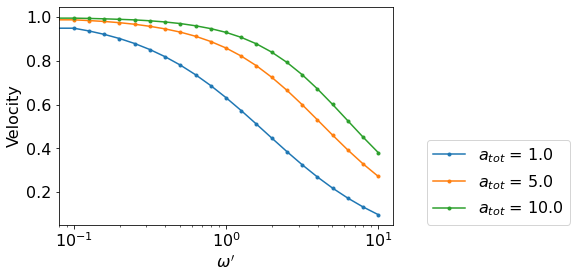

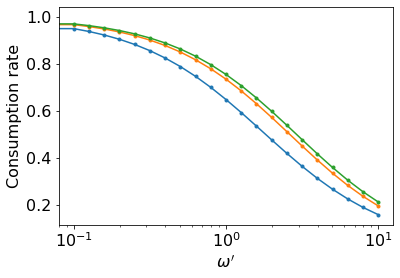

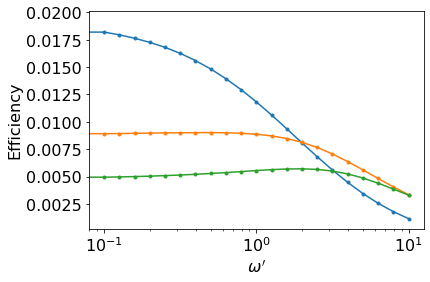

In [6]:
for i in range(len(a0s)):
    print(vs[i],max(vs[i]))
    plot(ws,vs[i]/max(vs[i]),".-",label = "$a_{tot}$ = "+str(a0s[i]))
xscale("log")
ylabel("Velocity",fontsize  =16)
xlabel(r"$\omega'$",fontsize  =16)
legend(loc = (1.1,0),fontsize = 16)
yticks(fontsize = 16)
xticks(fontsize = 16)
show()
for i in range(len(a0s)):
    plot(ws,burnt[i]/max(burnt[i]),".-")
xscale("log")
ylabel("Consumption rate",fontsize  =16)
xlabel(r"$\omega'$",fontsize  =16)
yticks(fontsize = 16)
xticks(fontsize = 16)
show()
for i in range(len(a0s)):
    plot(ws,vs[i]**2/burnt[i]/dG,".-")
xscale("log")
ylabel("Efficiency",fontsize  =16)
xlabel(r"$\omega'$",fontsize  =16)
yticks(fontsize = 16)
xticks(fontsize = 16)
show()

In [7]:
deltas = array([0.0,0.1,0.3,0.5,0.7])
delta_n = len(deltas)

vsd = []
burntd = []
for delta in deltas:
    astdy = a0/(1+koff)
    As = linspace(astdy,-astdy*5, Nx)
    As[xs>=0.0] = astdy
    vs1 = []
    burnt1 = []
    for w in ws:
        print(w)

        x0 = 0.0
        Ac = zeros(Nx)

        y0 = array([x0] + list(Ac) + list(As))

        sol = integrate.solve_ivp(lambda t, y: derivs(t, y, nu, xs, w, delta, a0, K, koff), (0., tf), y0, events=[event], method='BDF')

        v_final = derivs(sol.t[-1], sol.y[:,-1], nu, xs, w, delta, a0, K, koff)[0]  #dx/dt

        Acxf = sol.y[1:1+Nx,-1]
        btot = integrate.trapz(nu*Acxf, x=xs)

        vs1.append(v_final)
        burnt1.append(btot)
    
    vsd.append(vs1)
    burntd.append(burnt1)  
vsd = array(vsd)
burntd = array(burntd)

0.0
0.1
0.12589254117941673
0.15848931924611134
0.19952623149688797
0.251188643150958
0.31622776601683794
0.3981071705534973
0.5011872336272724
0.6309573444801934
0.7943282347242815
1.0
1.2589254117941675
1.584893192461114
1.9952623149688797
2.511886431509581
3.1622776601683795
3.981071705534973
5.011872336272725
6.309573444801933
7.943282347242818
10.0
0.0
0.1
0.12589254117941673
0.15848931924611134
0.19952623149688797
0.251188643150958
0.31622776601683794
0.3981071705534973
0.5011872336272724
0.6309573444801934
0.7943282347242815
1.0
1.2589254117941675
1.584893192461114
1.9952623149688797
2.511886431509581
3.1622776601683795
3.981071705534973
5.011872336272725
6.309573444801933
7.943282347242818
10.0
0.0
0.1
0.12589254117941673
0.15848931924611134
0.19952623149688797
0.251188643150958
0.31622776601683794
0.3981071705534973
0.5011872336272724
0.6309573444801934
0.7943282347242815
1.0
1.2589254117941675
1.584893192461114
1.9952623149688797
2.511886431509581
3.1622776601683795
3.9810717

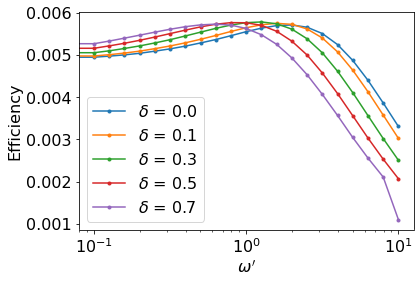

In [9]:
for i in range(delta_n):
    plot(ws,vsd[i]**2/burntd[i]/dG,".-",label = r"$\delta$ = " +str(round(deltas[i],3)))
    
legend(fontsize = 16)
yticks(fontsize = 16)
xticks(fontsize = 16)
xlabel(r"$\omega'$", fontsize =16)
ylabel("Efficiency", fontsize =16)
xscale("log")
    
